# Сборный проект — 2

Я работаю HR-аналитиком компании «Работа с заботой» и помогаю бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а наш отдел предлагает, как избежать финансовых потерь и оттока сотрудников.\
В своей работе мы используем машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками своих сотрудников. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 


**Цель проекта:** разработать решение, которое позволит бизнесу избежать финансовых потерь и оттока сотрудников:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Ход исследования:** \
Задача 1: предсказание уровня удовлетворённости сотрудника.\
Шаг 1 - Загрузка и изучение общей информации; \
Шаг 2 - Предобработка данных; \
Шаг 3 - Исследовательский анализ данных; \
Шаг 4 - Подготовка данных; \
Шаг 5 - Обучение моделей; \
Шаг 6 - Оформление выводов. 

Задача 2: предсказание увольнения сотрудника из компании.\
Шаг 1 - Загрузка и изучение общей информации; \
Шаг 2 - Предобработка данных; \
Шаг 3 - Исследовательский анализ данных; \
Шаг 4 - Добавление нового входного признака; \
Шаг 5 - Подготовка данных; \
Шаг 6 - Обучение моделей; \
Шаг 7 - Оформление выводов. 

Итоговый вывод. 

# Задача 1

## Шаг 1. Загрузка данных

Загружаем библиотеки, которые понадобятся в нашем исследовании

In [1]:
!pip install -q phik

In [2]:
!pip install -U scikit-learn -q

In [3]:
# импоритруем pandas для обработки, анализа и структурирования данных
import pandas as pd 
# импоритруем numpy для работы с данными
import numpy as np 
# так же импоритруем matplotlib.pyplot для будущего построения графиков
import matplotlib.pyplot as plt 
# так же импоритруем seaborn для построения графиков
import seaborn as sns 

# импоритруем phik для построения матрицы корреляций Фи
import phik 

# Импортируем функцию для переборки гиперпараметров
from sklearn.model_selection import RandomizedSearchCV

# Импортируем классы для кодирования и масштабирования
from sklearn.preprocessing import (
OneHotEncoder,
StandardScaler, 
OrdinalEncoder, 
MinMaxScaler
)
# Подключаем модели логистической регрессии, KNN, SVC, DTC.
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
# Подключаем метрики F1, ROC_AUC и т.д.
from sklearn.metrics import (
roc_auc_score,
make_scorer,
confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)

### 1.1 Загрузим данные из csv-файлов в датафреймы c помощью библиотеки pandas

In [4]:
try: # открываем наши файлы с данными в среде JupiterHUB:
    df_train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv') # представлена информация о тренировочной выборке
    df_test_features = pd.read_csv('/datasets/test_features.csv') # хранит данные о входных признаках тестовой выборки
    df_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv') # это данные о целевом признаке тестовой выборки
    
except: # либо берем данные на ПК для локальной версии Jupiter:
    df_train_job = pd.read_csv('C://Users//Voova//datasets//train_job_satisfaction_rate.csv') 
    df_test_features = pd.read_csv('C://Users//Voova//datasets//test_features.csv')
    df_test_target = pd.read_csv('C://Users//Voova//datasets//test_target_job_satisfaction_rate.csv')

### 1.2 Изучим общую информацию о датафреймах. Выведим первые строки наборов данных.

1.2.1 Посмотрим датафрейм `df_train_job`:

In [5]:
df_train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Перед нами датафрейм на **10** колонок и **4000** строк. В столбцах `dept` и `level` обнаружены пропущенные значения, займемся ими на этапе предобработки данных. \
Посмотрим первые 5 строчек таблицы:

In [6]:
df_train_job.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Типы данных корректные, данные в таблице соответствуют описанию.

1.2.2 Посмотрим датафрейм `df_test_features`:

In [7]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Перед нами датафрейм на **9** колонок и **2000** строк. В столбцах `dept` и `level` обнаружены пропущенные значения, займемся ими на этапе предобработки данных. \
Посмотрим первые 5 строчек таблицы:

In [8]:
df_test_features.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Типы данных корректные, данные в таблице соответствуют описанию.

1.2.3 Посмотрим датафрейм `df_test_target`:

In [9]:
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Перед нами датафрейм на **2** колонки и **2000** строк. пропуски данных не обнаружены. \
Посмотрим первые 5 строчек таблицы:

In [10]:
df_test_target.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Типы данных корректные, данные в таблице соответствуют описанию.

### 1.3 Вывод:
В нашем распоряжении датафреймы:
- `df_train_job` на **10** колонок и **4000** строк;
- `df_test_features` на **9** колонок и **2000** строк;
- `df_test_target` на **2** колонки и **2000** строк.
  
Названия столбцов соответствуют общепринятым нормам.
Пропуски в данных обнаружены в столбцах `dept` и `level` датафреймов `df_train_job` и `df_test_features`.

Для корректного исследования необходимо предобработать данные, а именно:
- Избавиться от пропусков в данных;
- Проверить датафреймы на явные/неявные дубликаты.

## Шаг 2. Предобработка данных

### 2.1 Исследование пропусков в данных: 

Посмотрим на пропущенные значения столбцах `dept` и `level` датафреймов `df_train_job` и `df_test_features`:

In [11]:
df_train_job[df_train_job['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [12]:
df_train_job[df_train_job['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [13]:
df_test_features[df_test_features['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [14]:
df_test_features[df_test_features['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


Явной зависимости в пропусках данных визуально не обнаружено.\
`По условию задачи заполнение пропусков необходимо провести в пайплайне на этапе обучения модели.`\
Для этого используем **SimpleImputer()** и заменим пропустки в категориальных признаках на самое распростроненное значение.

### 2.2 Проверка датафреймов на явные/неявные дубликаты:

2.2.1 Работаем с `df_train_job`

In [15]:
df_train_job.duplicated().sum() # выведим сумму явных дубикатов:

0

Проверим на неявные дубликаты остальные столбцы с категориальными данными: 

In [16]:
df_train_job['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

Неявные дубликаты не обнаружены.

In [17]:
df_train_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Неявные дубликаты не обнаружены, однако предлагаю исправить опечатку в уровне 'sEnior'.

In [18]:
df_train_job['level'] = df_train_job['level'].replace({'sinior':'senior'})

In [19]:
df_train_job['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

Неявные дубликаты не обнаружены.

In [20]:
df_train_job['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [21]:
df_train_job['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [22]:
#Проверяю количество неявных дубликатов по четырем столбцам:
df_train_job.duplicated(subset = ['id', 'dept', 'level', 'salary']).sum() 

0

Неявные дубликаты не обнаружены.

2.2.2 Работаем с `df_test_features`

In [23]:
df_test_features.duplicated().sum() # выведим сумму явных дубикатов:

0

Проверим на неявные дубликаты остальные столбцы с категориальными данными:

In [24]:
df_test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Обнаружен неявный дубликат, заменим пробел `' '` на nan:

In [25]:
df_test_features['dept'] = df_test_features['dept'].replace(' ', np.nan)

In [26]:
df_test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Неявные дубликаты не обнаружены, как и в предыдущем случае поправим опечатку:

In [27]:
df_test_features['level'] = df_test_features['level'].replace({'sinior':'senior'})

In [28]:
df_test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

Обнаружен пробел `' '`, который необходимо заменить на nan:

In [29]:
df_test_features['workload'] = df_test_features['workload'].replace(' ', np.nan)

In [30]:
df_test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [31]:
df_test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [32]:
#Проверяю количество неявных дубликатов по четырем столбцам:
df_test_features.duplicated(subset = ['id', 'dept', 'level', 'salary']).sum() 

0

Неявные дубликаты не обнаружены.

2.2.3 Работаем с `df_test_target`:

In [33]:
df_test_target.duplicated().sum() # выведим сумму явных дубикатов:

0

Дубликаты не обнаружены. 

### 2.3 Вывод:
На этапе предобработки данных была проведена проверка датафреймов на явные/неявные дубликаты.\
Обнаружены неявные дубликаты `' '`/nan в столбцах `workload` и `dept` датафрейма `df_test_features`. \
Данные пробелы заменены на nan, для дальнейшего заполнения пропусков в пайплайне на этапе обучения модели с использованием **SimpleImputer()**. 

## Шаг 3. Исследовательский анализ данных: 

### 3.1 Работаем с тренировочной выборкой `df_train_job`
Сначала пройдем по количественным признакам:
1. employment_years (длительность работы в компании (в годах)),
2. supervisor_evaluation (оценка качества работы сотрудника, которую дал руководитель),
3. salary (ежемесячная зарплата сотрудника),
4. job_satisfaction_rate (уровень удовлетворённости сотрудника работой в компании).

Далее посмотрим категориальные признаки:\
5. dept (отдел, в котором работает сотрудник),\
6. level (уровень занимаемой должности),\
7. workload (уровень загруженности сотрудника),\
8. last_year_promo (показывает, было ли повышение за последний год),\
9. last_year_violations (показывает, нарушал ли сотрудник трудовой договор за последний год).

1. Вызовем описательную функцию и построим гистограмму для *employment_years*:

In [34]:
df_train_job['employment_years'].describe()

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Аномальных значений не обнаружено.\
Построим гистограмму распределения сотрудников по длительности их работы в компании:

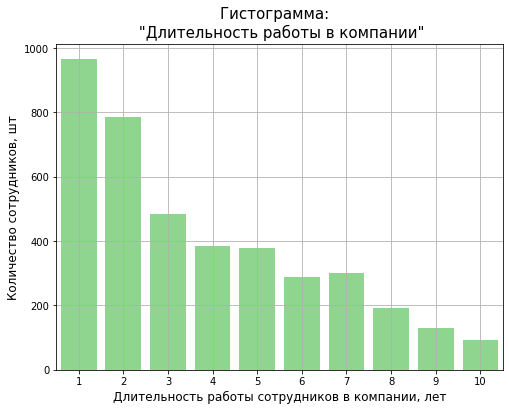

In [35]:
plt.figure(figsize = (8, 6))
sns.countplot (data = df_train_job,   
             x = 'employment_years',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Длительность работы в компании"', size = 15)
plt.xlabel('Длительность работы сотрудников в компании, лет', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Из гистограммы выше видно, что большинство сотрудников работают от 1 до 2 лет, тогда как среднее значение длительности составляет 3,7 лет. 

2. Вызовем описательную функцию и построим гистограмму для *supervisor_evaluation*:

In [36]:
df_train_job['supervisor_evaluation'].describe()

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Аномальных значений не обнаружено.\
Построим гистограмму распределения сотрудников по оценке качества работы, которую дал руководитель:

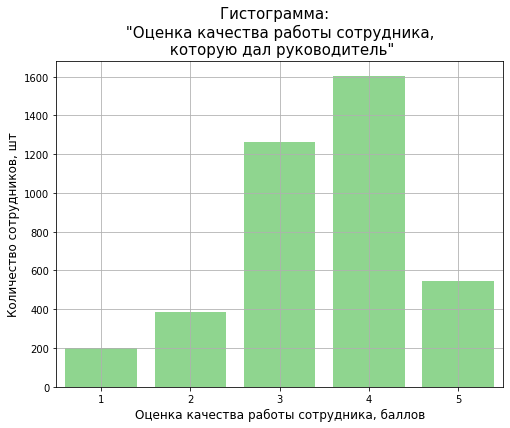

In [37]:
plt.figure(figsize = (8, 6))
sns.countplot(data = df_train_job,  
             x = 'supervisor_evaluation',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Оценка качества работы сотрудника, \n которую дал руководитель"', size = 15)
plt.xlabel('Оценка качества работы сотрудника, баллов', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Из гистограммы выше видно, что распределение оценок руководителем похоже на нормальное, со сдвигом вправо. \
Больше всего сотрудников с оценкой 4, тогда как, в среднем, оценка персонала глазами руководителя составляет 3,5 балла. 

3. Вызовем описательную функцию и построим гистограмму для *salary*:

In [38]:
df_train_job['salary'].describe()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

Для оценки выбросов построим боксплот: 

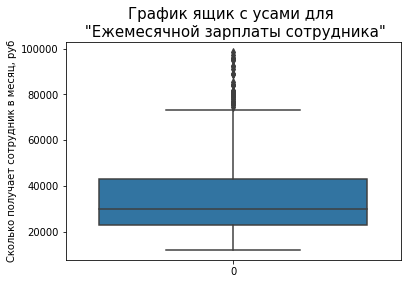

In [39]:
sns.boxplot(data = df_train_job['salary'])
plt.title('График ящик с усами для \n "Ежемесячной зарплаты сотрудника"', size = 15)
plt.ylabel('Сколько получает сотрудник в месяц, руб', size = 10)
plt.show()

На мой взгляд, выбросы в вопросе зарплаты сотрудников неизбежны - заработная плата руководителей, топов, особенно важных сотрудников может и должна в разы отличаться от средних или "вновь принятых" работников. Хотя выбросы и влияют на предсказания моделей - оставим их как есть. \
Построим гистограмму распределения заработной платы сотрудников:

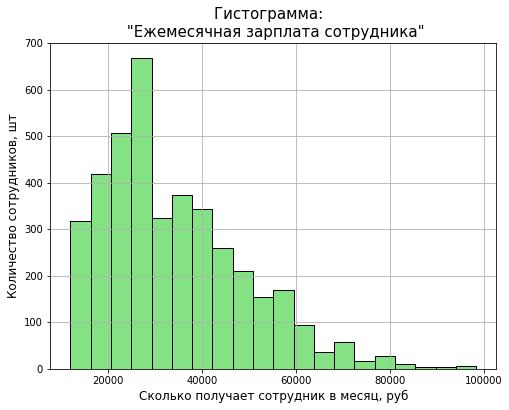

In [40]:
plt.figure(figsize = (8, 6))
sns.histplot(df_train_job, bins = 20,  
             x = 'salary',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Ежемесячная зарплата сотрудника"', size = 15)
plt.xlabel('Сколько получает сотрудник в месяц, руб', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Из гистограммы выше видно, что медианная зарплата в компании составляет 30000 рублей, эта сумма как раз не учитывает значения выбросов сумм руководителей. 

4. Вызовем описательную функцию и построим гистограмму для *job_satisfaction_rate*:

In [41]:
df_train_job['job_satisfaction_rate'].describe()

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Аномальные значения не обнаружены. \
Предлагаю взглянуть на удовлетворенность сотрудников работой в зависимости от отделов, в которых они работают: 

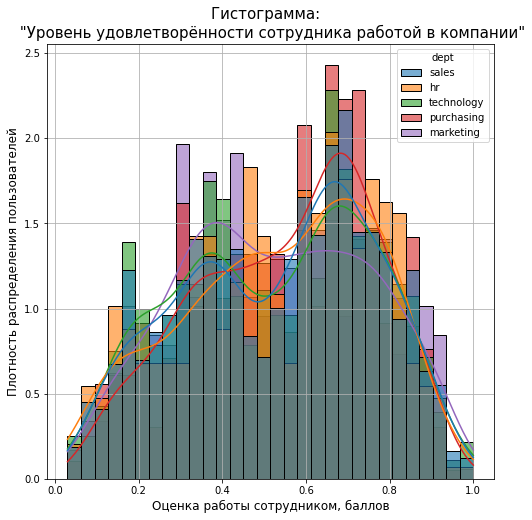

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

sns.histplot(df_train_job, bins = 30, 
             kde = True, ax=ax, 
             hue = 'dept', 
             x = 'job_satisfaction_rate',
             stat='density', 
             common_norm = False,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Уровень удовлетворённости сотрудника работой в компании"', size = 15)
plt.xlabel('Оценка работы сотрудником, баллов', size = 12)
plt.ylabel('Плотность распределения пользователей', size = 12)
plt.grid(True)
plt.show()

В среднем, работники компании удовлетворены своей работой на 0,53 балла. \
Работодателю есть куда расти. Распределение имеет бимодальный вид, где мы видим, что большинство сотрудников удовлетворены своей работой. \
Качество оценки не зависит от отдела работы сотрудника - в этом плане оценки распределены равномерно.

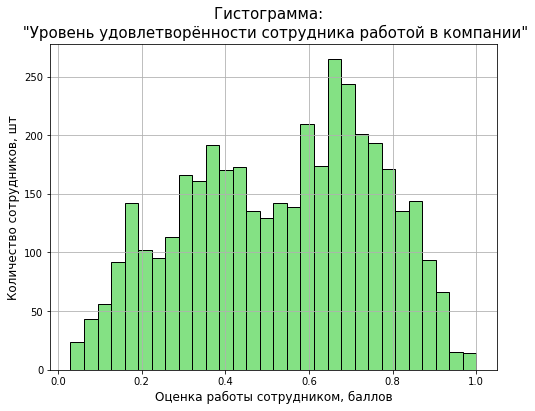

In [43]:
plt.figure(figsize = (8, 6))
sns.histplot(df_train_job, bins = 30,  
             x = 'job_satisfaction_rate',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Уровень удовлетворённости сотрудника работой в компании"', size = 15)
plt.xlabel('Оценка работы сотрудником, баллов', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Здесь уже бимодальность не так ярко выражена, как будто переходное состояние между нормальным распределением и бимодальностью. Всё же больше половины сотрудников удовлетворены своей работой, если поставим критерий удовлетворенности > 0,5 баллов. 

5. Построим круговую диаграмму для *dept*:

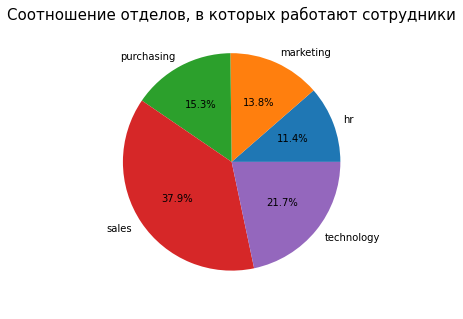

In [44]:
(
    df_train_job
    .groupby('dept')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение отделов, в которых работают сотрудники', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Как видно из круговой диаграммы - большинство работников работает в отделе продаж - порядка 40%.

6. Построим диаграмму для *level*:

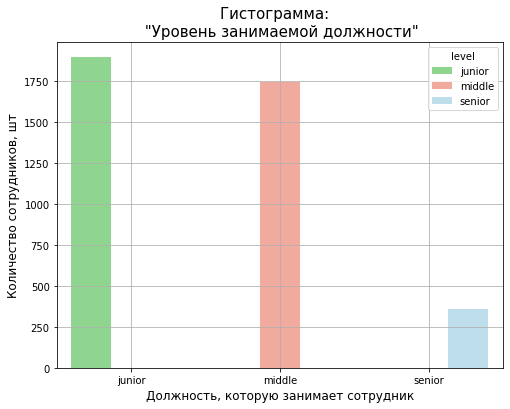

In [45]:
plt.figure(figsize = (8, 6))
palette = {'junior': 'limegreen', 'middle': 'tomato', 'senior' : 'skyblue'}
sns.countplot(data = df_train_job,   
             x = 'level', 
             hue = 'level',
             palette = palette,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Уровень занимаемой должности"', size = 15)
plt.xlabel('Должность, которую занимает сотрудник', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Большинство сотрудников компании - работники начального уровня, в то же время middle-работников немного меньше, но они тоже занимают значительную часть. 

7. Построим круговую диаграмму для *workload*:

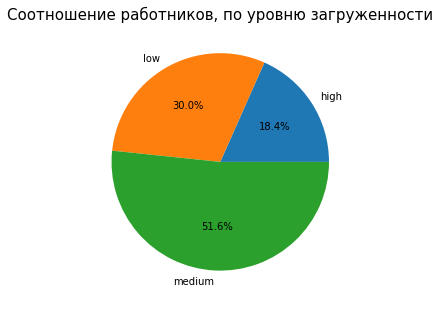

In [46]:
(
    df_train_job
    .groupby('workload')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение работников, по уровню загруженности', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Более половины работников имеют средний уровень загруженности, интересно - как этот уровень будет коррелировать с удовлетворенностью от работы.

8. Построим круговую диаграмму для *last_year_promo*:

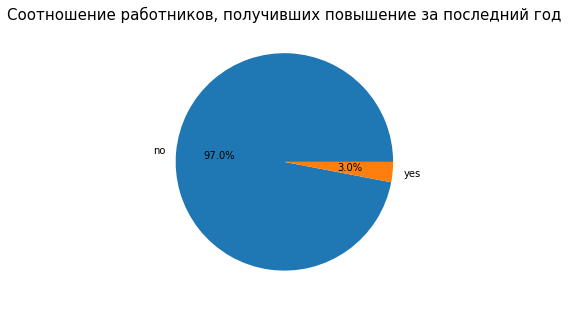

In [47]:
(
    df_train_job
    .groupby('last_year_promo')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение работников, получивших повышение за последний год', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Скромная статистика по продвижению по карьерной лестнице - всего 3% сотрудников получали повышение за год. Возможно это особенности работы в компании. 

9. Построим круговую диаграмму для *last_year_violations*:

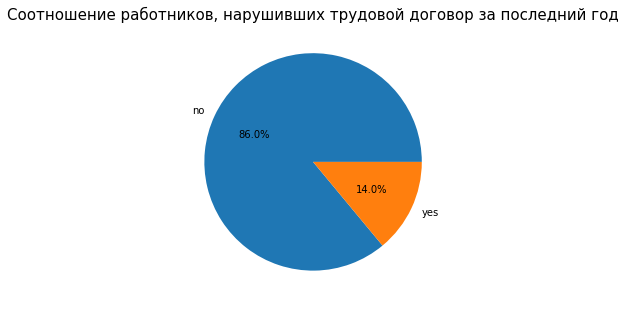

In [48]:
(
    df_train_job
    .groupby('last_year_violations')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение работников, нарушивших трудовой договор за последний год', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

За последний год было выявлено 14% нарушителей трудового договора, к счастью, большинство сотрудников добропорядочные. 

- Для корреляционного анализа будем использовать матрицу корреляций $\phi$, так как она хорошо улавливает взаимосвязи между количественными и категориальными значениями. 

In [49]:
# берем нашу полную таблицу, за исключением столбца ['id']
df_train_phik = df_train_job.drop('id', axis = 1)

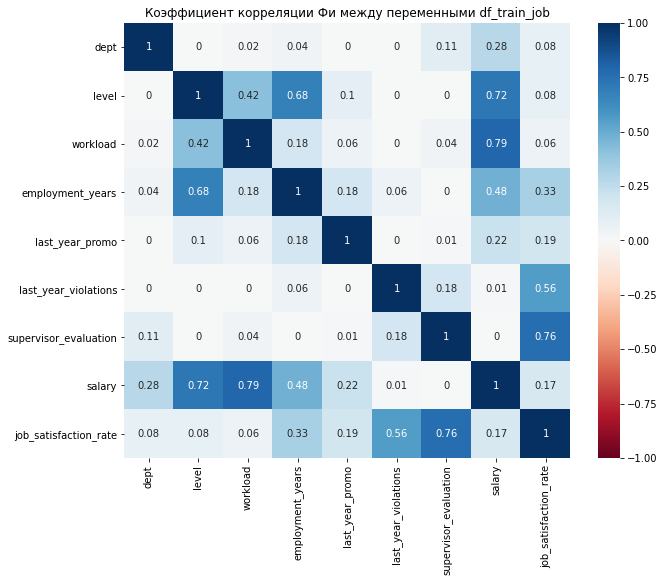

In [50]:
# Вычисляем матрицу корелляций Фи
phi_corr = df_train_phik.phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate'
                                                      ]).round(2)

# Строим ХитМэп корреляций Фи
plt.figure(figsize = (10, 8))
sns.heatmap(phi_corr, annot = True, cmap = 'RdBu', vmin = -1, vmax = 1)
plt.title("Коэффициент корреляции Фи между переменными df_train_job")
plt.show()

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`job_satisfaction_rate (уровень удовлетворённости сотрудника работой в компании)`**:
   - **Сильная корреляция**:
     - Прослеживается сильная положительная корреляция с `supervisor_evaluation` **(0,76)**. Следовательно, можно сделать вывод, что если руководитель работником доволен и они с ним в хороших отношениях - то и работой в компании сотрудник будет удовлетворен. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `last_year_violations` **(0,56)**, `employment_years` **(0,33)** показывает нам, что отсутствие нарушений трудового договора, а следовательно и санкций за эти нарушения положительно влияют на оценку удовлетворенности, так же как и длительность работы в компании: дольше работаешь - больше знаешь, всё больше попадаешь в зону комфорта и повышаешь уровень удовлетворенности работой.\

Так же отмечу высокую корреляцию занимаемой доолжности `level` с `salary` **(0,72)** и `employment_years` **(0,68)** - что говорит нам о том, что со временем персонал должен проходить через карьерный рост, что обеспечит повышение заработной платы. 

Нельзя не упомянуть, что высокозагруженные работники имеют большую заработную плату, и это отражено в самой высокой корреляции `workload` и `salary` **(0,79)**.

### 3.2 Работаем с входными признаками тестовой выборки `df_test_features`

По идее, если данные изначально корректно разделили на тестовую и тренировочную выборки - то данный шаг ничем не должен отличаться от предыдущего и все графики должны иметь такой же вид и распределение, так как деление на выборки происходит рандомно. Вот и проверим: 

Сначала пройдем по количественным признакам:
1. employment_years (длительность работы в компании (в годах)),
2. supervisor_evaluation (оценка качества работы сотрудника, которую дал руководитель),
3. salary (ежемесячная зарплата сотрудника),

Далее посмотрим категориальные признаки:\
4. dept (отдел, в котором работает сотрудник),\
5. level (уровень занимаемой должности),\
6. workload (уровень загруженности сотрудника),\
7. last_year_promo (показывает, было ли повышение за последний год),\
8. last_year_violations (показывает, нарушал ли сотрудник трудовой договор за последний год).

1. Вызовем описательную функцию и построим гистограмму для *employment_years*:

In [51]:
df_test_features['employment_years'].describe()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Аномальных значений не обнаружено.\
Построим гистограмму распределения сотрудников по длительности их работы в компании:

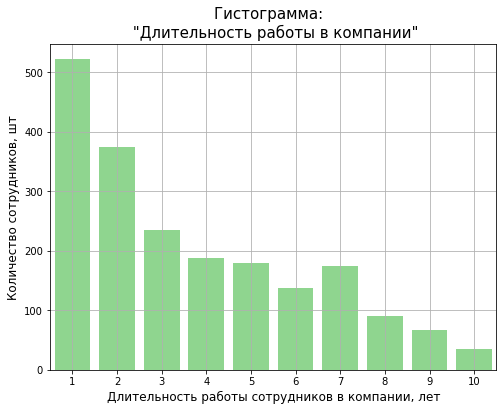

In [52]:
plt.figure(figsize = (8, 6))
sns.countplot(data = df_test_features,  
             x = 'employment_years',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Длительность работы в компании"', size = 15)
plt.xlabel('Длительность работы сотрудников в компании, лет', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Как и в тренировочной выборке, большинство сотрудников работают от 1 до 2 лет, тогда как среднее значение длительности составляет 3,7 лет.

2. Вызовем описательную функцию и построим гистограмму для *supervisor_evaluation*:

In [53]:
df_test_features['supervisor_evaluation'].describe()

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Аномальных значений не обнаружено.\
Построим гистограмму распределения сотрудников по оценке качества работы, которую дал руководитель:

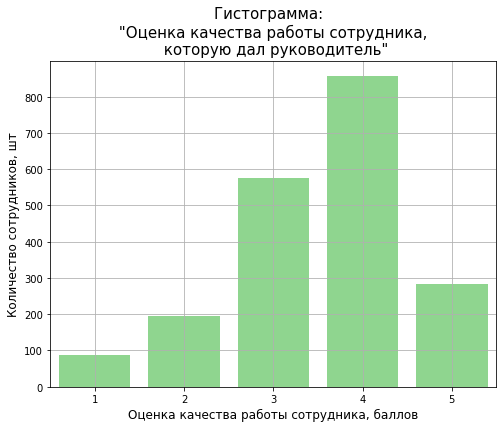

In [54]:
plt.figure(figsize = (8, 6))
sns.countplot(data = df_test_features,  
             x = 'supervisor_evaluation',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Оценка качества работы сотрудника, \n которую дал руководитель"', size = 15)
plt.xlabel('Оценка качества работы сотрудника, баллов', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Как и в тренировочной выборке, распределение оценок руководителем похоже на нормальное, со сдвигом вправо. \
Больше всего сотрудников с оценкой 4, тогда как, в среднем, оценка персонала глазами руководителя составляет 3,5 балла. 

3. Вызовем описательную функцию и построим гистограмму для *salary*:

In [55]:
df_test_features['salary'].describe()

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

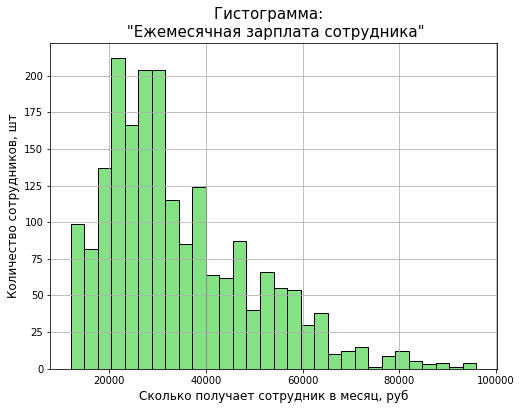

In [56]:
plt.figure(figsize = (8, 6))
sns.histplot(df_test_features, bins = 30,  
             x = 'salary',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Ежемесячная зарплата сотрудника"', size = 15)
plt.xlabel('Сколько получает сотрудник в месяц, руб', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Как и в тестовой выборке, видно, что медианная зарплата в компании составляет 30000 рублей, эта сумма как раз не учитывает значения выбросов сумм руководителей. 

4. Построим круговую диаграмму для *dept*:

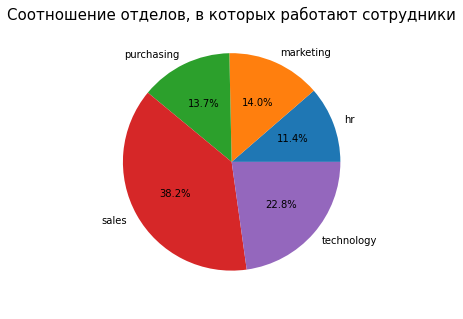

In [57]:
(
    df_test_features
    .groupby('dept')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение отделов, в которых работают сотрудники', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Как видно из круговой диаграммы - большинство работников работает в отделе продаж - порядка 40%. 
- Можно с уверенностью сказать, что выборки поделены корректно, так как информация в тестовой и тренировочной выборках идентичная. 

5. Построим диаграмму для *level*:

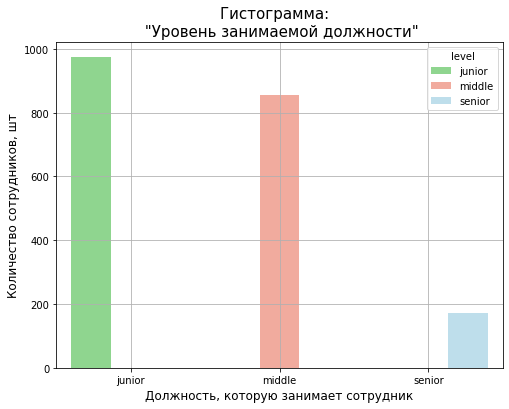

In [58]:
plt.figure(figsize = (8, 6))
palette = {'junior': 'limegreen', 'middle': 'tomato', 'senior' : 'skyblue'}
sns.countplot(data = df_test_features,   
             x = 'level', 
             hue = 'level',
             palette = palette,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Уровень занимаемой должности"', size = 15)
plt.xlabel('Должность, которую занимает сотрудник', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Соотношение должностей прямо пропорционально тренировочной выборке. 

6. Построим круговую диаграмму для *workload*:

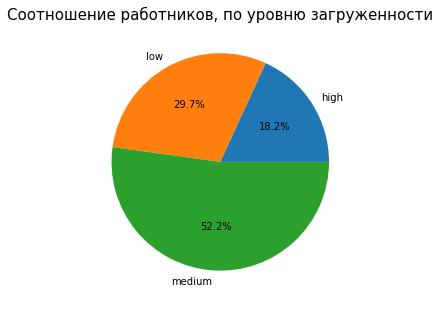

In [59]:
(
    df_test_features
    .groupby('workload')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение работников, по уровню загруженности', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Соотношение загруженности прямо пропорционально тренировочной выборке. 

7. Построим круговую диаграмму для *last_year_promo*:

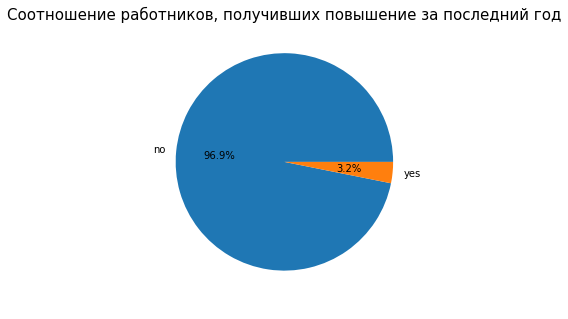

In [60]:
(
    df_test_features
    .groupby('last_year_promo')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение работников, получивших повышение за последний год', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Соотношение повышений прямо пропорционально тренировочной выборке. 

8. Построим круговую диаграмму для *last_year_violations*:

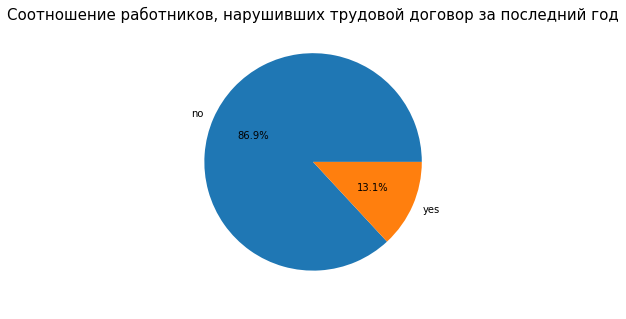

In [61]:
(
    df_test_features
    .groupby('last_year_violations')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение работников, нарушивших трудовой договор за последний год', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Соотношение нарушителей прямо пропорционально тренировочной выборке. 

In [62]:
# берем нашу полную таблицу, за исключением столбца ['id']
df_train_phik_two = df_test_features.drop('id', axis = 1)

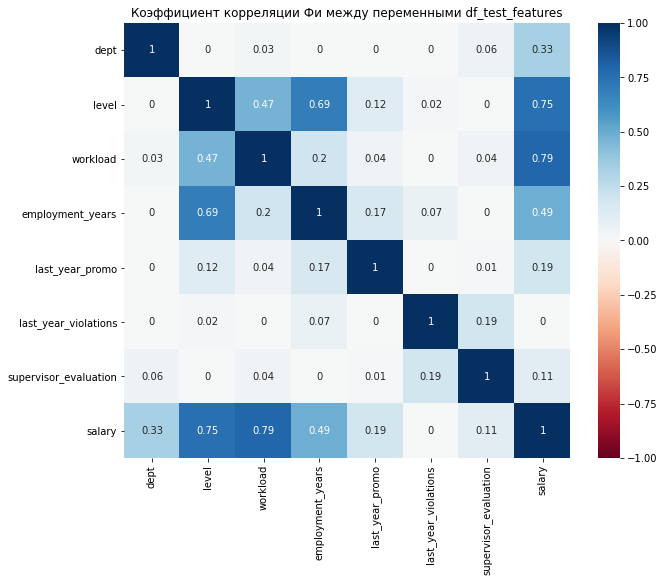

In [63]:
# Вычисляем матрицу корелляций Фи
phi_corr = df_train_phik_two.phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate'
                                                      ]).round(2)

# Строим ХитМэп корреляций Фи
plt.figure(figsize = (10, 8))
sns.heatmap(phi_corr, annot = True, cmap = 'RdBu', vmin = -1, vmax = 1)
plt.title("Коэффициент корреляции Фи между переменными df_test_features")
plt.show()

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов корреляции:  
   - **Сильные корреляции**:
     - Занимаемая должность `level` с `salary` **(0,72)** и `employment_years` **(0,68)** - что говорит нам о том, что со временем персонал должен проходить через карьерный рост, что обеспечит повышение заработной платы.  
     - Высокозагруженные работники имеют большую заработную плату, и это отражено в самой высокой корреляции `workload` и `salary` **(0,79)**.
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция `level` и `workload` **(0,47)** показывает нам, что нагрузка не обязательно, но будет увеличиваться по мере роста занимаемой должности. 
     - Умеренная положительная корреляция `employment_years` и `salary` **(0,49)** говорит о том, что с увеличением длительности работы в компании заработная плата будет увеличиваться - чем дольше работаешь - больше знаешь/больше делаешь/больше получаешь.

### 3.2 Работаем с целевым признаком тестовой выборки `df_test_target`

Как и в предыдущем шаге, данные должны быть пропорциональны тренировочной выборке, давайте в этом убедимся:

Вызовем описательную функцию и построим гистограмму для *job_satisfaction_rate*:

In [64]:
df_test_target['job_satisfaction_rate'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

Аномальные значения не обнаружены. 

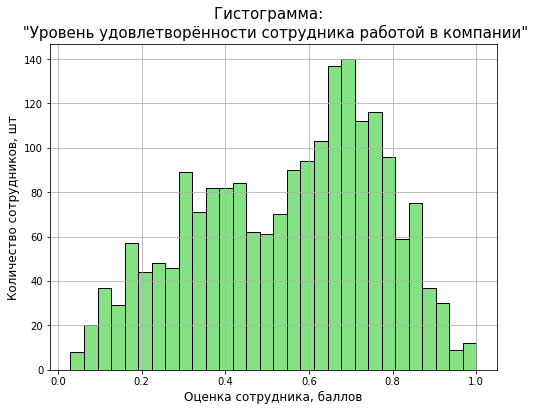

In [65]:
plt.figure(figsize = (8, 6))
sns.histplot(df_test_target, bins = 30,  
             x = 'job_satisfaction_rate',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Уровень удовлетворённости сотрудника работой в компании"', size = 15)
plt.xlabel('Оценка сотрудника, баллов', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

В среднем, работники компании удовлетворены своей работой на 0,55 баллов. Данные пропорциональны тренировочной выборке. 

### ВЫВОД по разделу:
- Большинство сотрудников работают в компании от 1 до 2 лет, тогда как среднее значение длительности составляет 3,7 лет.
- Распределение оценок руководителем похоже на нормальное, со сдвигом вправо.\
Больше всего сотрудников с оценкой 4, тогда как, в среднем, оценка персонала глазами руководителя составляет 3,5 балла.
- Медианная зарплата в компании составляет 30000 рублей, эта сумма не учитывает высокие значения заработных плат руководителей.
- В среднем, работники компании удовлетворены своей работой на 0,53 балла.\
Работодателю есть куда расти. Распределение имеет бимодальный вид, где мы видим, что большинство сотрудников удовлетворены своей работой.
- Большинство работников работает в отделе продаж - порядка 40%.
- Большинство сотрудников компании - работники начального уровня, в то же время middle-работников немного меньше, но они тоже занимают значительную часть.
- Более половины работников имеют средний уровень загруженности.
- Скромная статистика по продвижению по карьерной лестнице - всего 3% сотрудников получали повышение за год. 
- За последний год было выявлено 14% нарушителей трудового договора, к счастью, большинство сотрудников добропорядочные.

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`job_satisfaction_rate (уровень удовлетворённости сотрудника работой в компании)`**:
   - **Сильная корреляция**:
     - Прослеживается сильная положительная корреляция с `supervisor_evaluation` **(0,76)**. Следовательно, можно сделать вывод, что если руководитель работником доволен и они с ним в хороших отношениях - то и работой в компании сотрудник будет удовлетворен. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `last_year_violations` **(0,56)**, `employment_years` **(0,33)** показывает нам, что отсутствие нарушений трудового договора, а следовательно и санкций за эти нарушения положительно влияют на оценку удовлетворенности, так же как и длительность работы в компании: дольше работаешь - больше знаешь, всё больше попадаешь в зону комфорта и повышаешь уровень удовлетворенности работой.\

Так же отмечу высокую корреляцию занимаемой доолжности `level` с `salary` **(0,72)** и `employment_years` **(0,68)** - что говорит нам о том, что со временем персонал должен проходить через карьерный рост, что обеспечит повышение заработной платы. 

Нельзя не упомянуть, что высокозагруженные работники имеют большую заработную плату, и это отражено в самой высокой корреляции `workload` и `salary` **(0,79)**.

Посмотрим на выделяющиеся значения коэффициентов корреляции тестовой выборки `df_test_features`:  
   - **Сильные корреляции**:
     - Занимаемая должность `level` с `salary` **(0,72)** и `employment_years` **(0,68)** - что говорит нам о том, что со временем персонал должен проходить через карьерный рост, что обеспечит повышение заработной платы.  
     - Высокозагруженные работники имеют большую заработную плату, и это отражено в самой высокой корреляции `workload` и `salary` **(0,79)**.
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция `level` и `workload` **(0,47)** показывает нам, что нагрузка не обязательно, но будет увеличиваться по мере роста занимаемой должности. 
     - Умеренная положительная корреляция `employment_years` и `salary` **(0,49)** говорит о том, что с увеличением длительности работы в компании заработная плата будет увеличиваться - чем дольше работаешь - больше знаешь/больше делаешь/больше получаешь.

## Шаг 4. Подготовка данных

Наши данные изначально были разделены на тренировочную, тестовую и целевую тестовую выборки.
Мы переберем модели **DecisionTreeRegressor()** и **LogisticRegression()** используя пайплайны.

In [66]:
# Так как столбец ID напрямую коррелирует с уровнем удовлетворености, сделаем его индексом, чтобы видеть в будущем какие пользователи конкретно
# могут быть нам инетерсно в персональной работе по увеличению удовлетворённости сотрудника работой в компании
df_train_job = df_train_job.set_index('id')
df_train_job.drop_duplicates(inplace = True)

По условию задачи нам необходимо для кодирования категориальных признаков использовать как минимум два кодировщика:\
OneHotEncoder поможет нам закодировать бинарные переменные. \
OrdinalEncoder обычно используется, если важен естественный порядок.

- Перечислим особенности данных:\
Целевой признак — `job_satisfaction_rate (уровень удовлетворённости сотрудника работой в компании)`.\
Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью `OneHotEncoder`.\
Два признака: `workload` и `level` — закодируем с помощью `OrdinalEncoder`.\
Остальные количественные признаки необходимо масштабировать.

In [67]:
# Используемые константы
RANDOM_STATE = 42

In [68]:
X_train = df_train_job.drop(['job_satisfaction_rate'], axis = 1)
y_train = df_train_job['job_satisfaction_rate']

In [69]:
# введем обозначение для типов исходных данных:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['workload', 'level']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [70]:
# Добавляем OHE-кодирование в пайплайн
try:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') # заполняем пропуски из шага предобработки данных
        ),
        (
            'ohe', 
            OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)
        )
    ]
) 
except:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
        )
    ]
) 

In [71]:
# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                    ['low', 'medium', 'high'], 
                    ['junior', 'middle', 'senior'] 
                ], 
                handle_unknown = 'use_encoded_value', unknown_value = np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )
    ]
) 

In [72]:
#Объединяем шаги подготовки
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder = 'passthrough' 
) 

In [73]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
) 

## Шаг 5. Обучение моделей

In [74]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 15), #  ограничивает максимальную глубину дерева
        'models__min_samples_split': range(2, 15),
        'models__max_features': range(2, 15), # контролирует максимальное количество признаков, рассматриваемых при каждом разбиении узла в дереве
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Мы можем перебрать гиперпараметры тремя методами: 
1. GridSearchCV - это метод (его ещё называют поиск по сетке), который перебирает все возможные комбинации гиперпараметров, что может быть вычислительно дорого.
2. RandomizedSearchCV - это метод случайного поиска гиперпараметров (проверяет только случайное подмножество комбинаций), который часто оказывается более эффективным, чем полный перебор.
3. OptunaSearchCV - (Байесовская оптимизация) - это итерационный метод, на каждой итерации определяется, в какой следующей точке с наибольшей вероятностью можно получить лучший результат.

Для нашего исследования я выбрал модель `RandomizedSearchCV` - так как она позволяет быстрее найти хорошие параметры, хотя и жертвуя полной оптимальностью.

Напишем функцию, которая возвращает значение метрики SMAPE:\
SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»):

\begin{alignat}{2}
{SMAPE} = \frac{100}{n}\sum_{i=1}^{n}{\frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}},
\end{alignat}

где:\
$y_i$ - фактическое значение целевого признака для объекта с порядковым номером i в выборке;\
$\hat{y_i}$ - предсказанное значение целевого признака для объекта с порядковым номером i в выборке;\
n - количество объектов в выборке;\
$\sum_{i=1}^{n}$ - сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от i до n в выборке.

Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

In [75]:
def smape(y_true, y_pred):
    metric = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return metric

In [76]:
# для создания своей метрики используем функцию make_scorer()
custom_scorer = make_scorer(score_func = smape, greater_is_better = False)

In [77]:
# выполним автоматизированный поиск гиперпараметров с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = custom_scorer,
    random_state = RANDOM_STATE,
    n_jobs = -1
)

### 5.1 Выберим лучшую модель: 
Посмотрим ТОП-5 моделей:

In [78]:
randomized_search.fit(X_train, y_train)
pd.DataFrame(randomized_search.cv_results_).sort_values(by = 'rank_test_score', ascending = True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.025264,0.000414,0.011245,0.000122,StandardScaler(),11,8,12,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.959412,-15.174706,-16.261387,-15.884804,-15.211966,-15.698455,0.431440,1
1,0.024001,0.000500,0.010746,0.000461,passthrough,3,10,12,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-15.758001,-14.970731,-16.385377,-16.440971,-15.363495,-15.783715,0.571345,2
7,0.024491,0.000477,0.011581,0.000699,MinMaxScaler(),9,6,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-15.588002,-15.005941,-16.846585,-16.611844,-15.476893,-15.905853,0.704028,3
6,0.023457,0.000418,0.011251,0.000261,MinMaxScaler(),14,5,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-16.562120,-15.003907,-16.691765,-16.039309,-15.684377,-15.996296,0.614461,4
2,0.023610,0.000308,0.010948,0.000201,StandardScaler(),14,5,12,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-16.599022,-15.860303,-17.127554,-16.325196,-15.804992,-16.343413,0.490681,5


Все ТОП-5 позиций удерживает **DecisionTreeRegressor()**.

In [79]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', -(randomized_search.best_score_))
print('Параметры лучшей модели: \n', randomized_search.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Посмотрим на значения нашей метрики на тестовой выборке: 

In [80]:
# для начала соберем полную тестовую выборку:
df_test_features_full = df_test_features.merge(df_test_target, on = 'id', how = 'left')
# сделаем столбец ID индексом
df_test_features_full = df_test_features_full.set_index('id')
# выделим входящий и целевой признаки - вроде бы делаем обратное действие, но теперь наши выборки упорядочены по ID: 
X_test = df_test_features_full.drop(['job_satisfaction_rate'], axis = 1)
y_test = df_test_features_full['job_satisfaction_rate']
# обозначаем нашу лучшую модель:
best_model = randomized_search.best_estimator_

In [81]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)), 2)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.05


Критерий успеха выполнен.

In [82]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
preds = dummy_regr.predict(X_test)
print(f'Метрика SMAPE Dummy модели на тестовой выборке: {round(smape(y_test, preds), 2)}')

Метрика SMAPE Dummy модели на тестовой выборке: 38.26


Получается, не зря делали модель - наши предсказания точнее.

## Шаг 6 Выводы по задаче:
На 5 шаге мы перебрали на тестовой выборке модели **LinearRegression()** и **DecisionTreeRegressor()** используя пайплайны.\
Лучшей моделью по метрике **SMAPE** оказалось **Дерево решений** со следующими параметрами:\
`models__min_samples_split`= **11**,\
`models__max_features` = **8**, \
`models__max_depth` = **12**.

*Метрика* **SMAPE** на тренировойной выборке: **15,70**

*Метрика* **SMAPE** на тестовой выборке: **14,05**

Показатели метрики хорошие, критерий успеха выполняется. 

На мой взгляд, в данной ситуации, качество моделей дерева решений лучше, так как DecisionTree автоматически находит сложные нелинейные закономерности, разбивая данные на области - а как мы видили в матрице корреляций Фи - у нас многие параметры слабо коррелируют между собой или не коррелируют вовсе. \
Логистическая регрессия ищет в первую очередь линейные связи, которых в наших данных не много. 

# Задача 2

## Шаг 1. Загрузка данных/2

### 1.1 Загрузим данные из csv-файлов в датафреймы c помощью библиотеки pandas/2

In [83]:
try: # открываем наши файлы с данными в среде JupiterHUB:
    df_train_quit = pd.read_csv('/datasets/train_quit.csv') # представлена информация о тренировочной выборке
   # df_test_features = остается тот же самый от 1 задачи - мы уже исследовали его.
    df_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv') # это данные о целевом признаке тестовой выборки
    
except: # либо берем данные на ПК для локальной версии Jupiter:
    df_train_quit = pd.read_csv('C://Users//Voova//datasets//train_quit.csv') 
    # df_test_features = остается тот же самый от 1 задачи - мы уже исследовали его.
    df_test_target_quit = pd.read_csv('C://Users//Voova//datasets//test_target_quit.csv')

### 1.2 Изучим общую информацию о датафреймах. Выведим первые строки наборов данных/2

1.2.1 Посмотрим датафрейм `df_train_quit`:

In [84]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Перед нами датафрейм на **10** колонок и **4000** строк. Пропущенные значения не обнаружены. \
Посмотрим первые 5 строчек таблицы:

In [85]:
df_train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Типы данных корректные, данные в таблице соответствуют описанию.

1.2.2 Датафрейм `df_test_features`не изменился с прошлой задачи, берем его как есть, уже предобработанный и проанализированный. 

In [86]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Типы данных корректные, данные в таблице соответствуют описанию. Пропуски заполним в пайплайне на этапе сборки модели. 

1.2.3 Посмотрим датафрейм `df_test_target_quit`:

In [87]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Перед нами датафрейм на **2** колонки и **2000** строк. Пропуски данных не обнаружены. \
Посмотрим первые 5 строчек таблицы:

In [88]:
df_test_target_quit.head(5)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Типы данных корректные, данные в таблице соответствуют описанию.

### 1.3 Вывод/2:
В нашем распоряжении датафреймы:
- `df_train_quit` на **10** колонок и **4000** строк;
- `df_test_features` на **9** колонок и **2000** строк;
- `df_test_target_quit` на **2** колонки и **2000** строк.
  
Названия столбцов соответствуют общепринятым нормам.
Пропуски в данных имеются в датафрейме `df_test_features`, но они будут обработаны на этапе конструирования пайплайна. 

Для корректного исследования необходимо предобработать данные, а именно:
- Проверить датафреймы на явные/неявные дубликаты.

## Шаг 2. Предобработка данных/2

### 2.1 Проверка датафреймов на явные/неявные дубликаты:

2.1.1 Работаем с `df_train_quit`

In [89]:
df_train_quit.duplicated().sum() # выведим сумму явных дубикатов:

0

Проверим на неявные дубликаты остальные столбцы с категориальными данными: 

In [90]:
df_train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

Неявные дубликаты не обнаружены.

In [91]:
df_train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

Неявные дубликаты не обнаружены, однако предлагаю исправить опечатку в уровне 'sEnior'.

In [92]:
df_train_quit['level'] = df_train_quit['level'].replace({'sinior':'senior'})

In [93]:
df_train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

Неявные дубликаты не обнаружены.

In [94]:
df_train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [95]:
df_train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [96]:
df_train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты не обнаружены.

In [97]:
#Проверяю количество неявных дубликатов по четырем столбцам:
df_train_quit.duplicated(subset = ['id', 'dept', 'level', 'salary']).sum() 

0

Неявные дубликаты не обнаружены.

2.1.2 Работаем с `df_test_target_quit`:

In [98]:
df_test_target_quit.duplicated().sum() # выведим сумму явных дубикатов:

0

Дубликаты не обнаружены. 

### 2.2 Вывод/2:
На этапе предобработки данных была проведена проверка датафреймов на явные/неявные дубликаты, дубликаты не обнаружены.

## Шаг 3. Исследовательский анализ данных:/2 

### 3.1 Работаем с тренировочной выборкой `df_train_quit`/2
Сначала пройдем по количественным признакам и будем их рассматривать в контексте целевого признака - **quit**
1. employment_years (длительность работы в компании (в годах)),
2. supervisor_evaluation (оценка качества работы сотрудника, которую дал руководитель),
3. salary (ежемесячная зарплата сотрудника),

Далее посмотрим категориальные признаки:\
4. dept (отдел, в котором работает сотрудник),\
5. level (уровень занимаемой должности),\
6. workload (уровень загруженности сотрудника),\
7. last_year_promo (показывает, было ли повышение за последний год),\
8. last_year_violations (показывает, нарушал ли сотрудник трудовой договор за последний год),\
9. quit (увольнение сотрудника из компании).

1. Вызовем описательную функцию и построим гистограмму для *employment_years*:

In [99]:
df_train_quit['employment_years'].describe()

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Аномальных значений не обнаружено.\
Построим гистограмму распределения сотрудников по длительности их работы в компании:

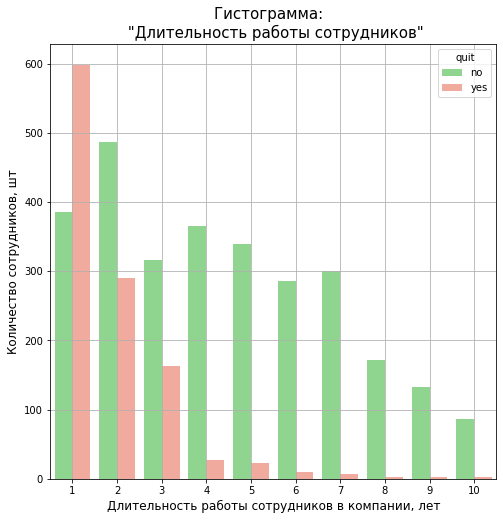

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit, 
             ax=ax, 
             hue = 'quit', 
             x = 'employment_years',
             palette = palette,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Длительность работы сотрудников"', size = 15)
plt.xlabel('Длительность работы сотрудников в компании, лет', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Распределение максимально похоже на данные из 1 задачи, я бы даже сказал, что это те же самые данные.\
Из гистограммы выше видно, что большинство уволившихся сотрудников отработало 1-2 года.

2. Вызовем описательную функцию и построим гистограмму для *supervisor_evaluation*:

In [101]:
df_train_quit['supervisor_evaluation'].describe()

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Аномальных значений не обнаружено.\
Построим гистограмму распределения сотрудников по оценке качества работы, которую дал руководитель:

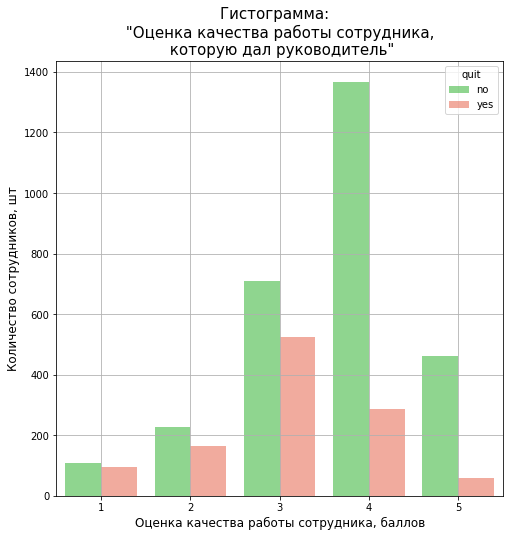

In [102]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit, 
             ax=ax, 
             hue = 'quit', 
             x = 'supervisor_evaluation',
             palette = palette,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Оценка качества работы сотрудника, \n которую дал руководитель"', size = 15)
plt.xlabel('Оценка качества работы сотрудника, баллов', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Из гистограммы выше видно, что распределение оценок руководителем похоже на нормальное, со сдвигом вправо. \
Больше всего сотрудников с оценкой 4, тогда как, в среднем, оценка персонала глазами руководителя составляет 3,5 балла. 

Большинство уволившихся сотрудников оценены руководителем на 3 балла. 

3. Вызовем описательную функцию и построим гистограмму для *salary*:

In [103]:
df_train_quit['salary'].describe()

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Оценку выбросам мы дали в предыдущей задаче, построим гистограмму распределения заработной платы сотрудников:

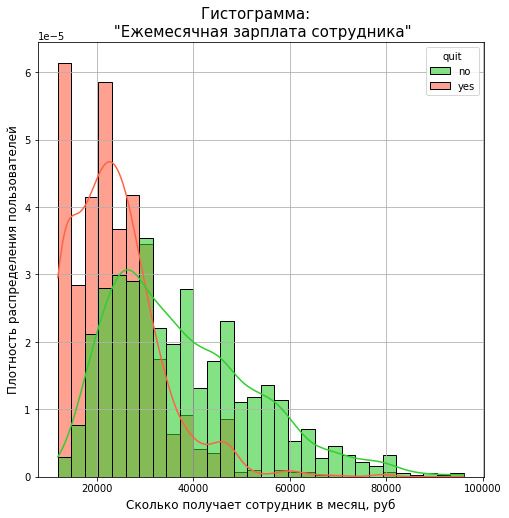

In [104]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.histplot(df_train_quit, bins = 30, 
             kde = True, ax=ax, 
             hue = 'quit', 
             x = 'salary',
             stat ='density',
             common_norm = False,
             palette = palette,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Ежемесячная зарплата сотрудника"', size = 15)
plt.xlabel('Сколько получает сотрудник в месяц, руб', size = 12)
plt.ylabel('Плотность распределения пользователей', size = 12)
plt.grid(True)
plt.show()

Из гистограммы видно, что наиболее склонны к увольнению сотрудники с минимальным размером оплаты труда. Работники с окладом в 12000 рублей особено не задерживаются в компании.

4. Построим диаграмму для *dept*:

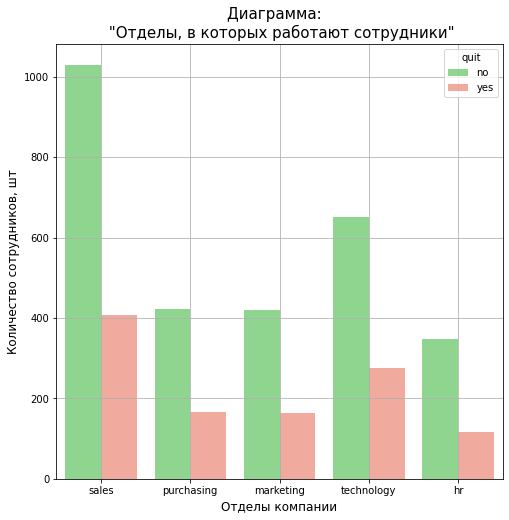

In [105]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit, 
             ax=ax, 
             hue = 'quit', 
             x = 'dept',
             palette = palette,
             alpha = 0.6)
plt.title('Диаграмма:  \n "Отделы, в которых работают сотрудники"', size = 15)
plt.xlabel('Отделы компании', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Так как большинство работников работает в отделе продаж - порядка 40%, то и потери у этого отдела самые большие. Не все работники могут быть хорошими продажниками. 

5. Построим диаграмму для *level*:

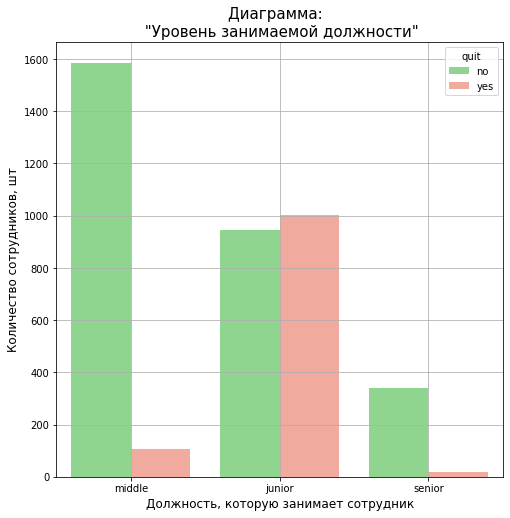

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit,
             ax=ax, 
             hue = 'quit', 
             x = 'level',
             palette = palette,
             alpha = 0.6)
plt.title('Диаграмма:  \n "Уровень занимаемой должности"', size = 15)
plt.xlabel('Должность, которую занимает сотрудник', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

В отличие от 1 задачи - большинство сотрудников компании middle-работники (возможно рассматривается другой момент времени), однако основной риск увольнения несет в себе категория junior.

6. Построим диаграмму для *workload*:

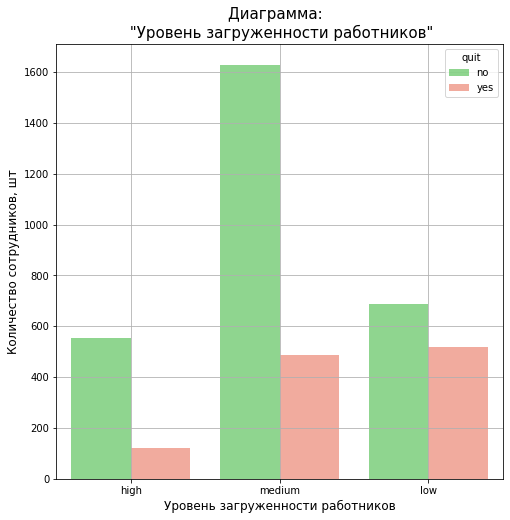

In [107]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit,
             ax=ax, 
             hue = 'quit', 
             x = 'workload',
             palette = palette,
             alpha = 0.6)

plt.title('Диаграмма:  \n "Уровень загруженности работников"', size = 15)
plt.xlabel('Уровень загруженности работников', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Как мы помним, уровень загруженности очень сильно коррелирует с уровнем заработной платы - поэтому *высоконагруженные=высокооплачиваемые* работники не торопятся покидать компанию. 

7. Построим диаграмму для *last_year_promo*:

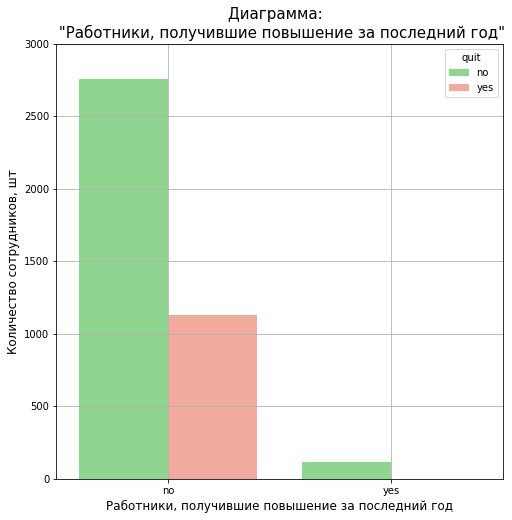

In [108]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit,
             ax=ax, 
             hue = 'quit', 
             x = 'last_year_promo',
             palette = palette,
             alpha = 0.6)
plt.ylim(0, 3000)
plt.title('Диаграмма:  \n "Работники, получившие повышение за последний год"', size = 15)
plt.xlabel('Работники, получившие повышение за последний год', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Естественно, работники, получившие продвижение по карьерной лестнице не торопятся покидать компанию - тогда как почти половина сотрудников без повышения в хоне риска на увольнение.  

8. Построим диаграмму для *last_year_violations*:

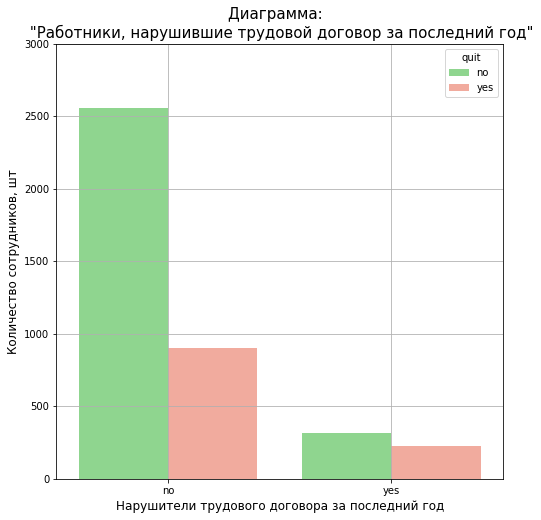

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.countplot(data = df_train_quit,
             ax=ax, 
             hue = 'quit', 
             x = 'last_year_violations',
             palette = palette,
             alpha = 0.6)
plt.ylim(0, 3000)
plt.title('Диаграмма:  \n "Работники, нарушившие трудовой договор за последний год"', size = 15)
plt.xlabel('Нарушители трудового договора за последний год', size = 12)
plt.ylabel('Количество сотрудников, шт', size = 12)
plt.grid(True)
plt.show()

Среди нарушителей трудового договора большая доля уволившихся сотрудников, что логично. \
Нарушения трудовой дисциплины оказывают ущерб работодателю - работодатель накладывает санкции на работника. 

9. Построим круговую диаграмму для *quit*:

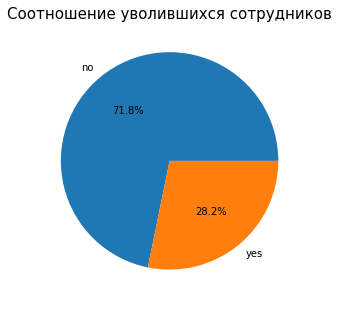

In [110]:
(
    df_train_quit
    .groupby('quit')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение уволившихся сотрудников', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Как видно из круговой диаграммы - почти одна треть (порядка 28%) сотрудников увольняется по тем или иным причинам.

- Для корреляционного анализа будем использовать матрицу корреляций $\phi$, так как она хорошо улавливает взаимосвязи между количественными и категориальными значениями. 

In [111]:
# берем нашу полную таблицу, за исключением столбца ['id']
df_train_phik = df_train_quit.drop('id', axis = 1)

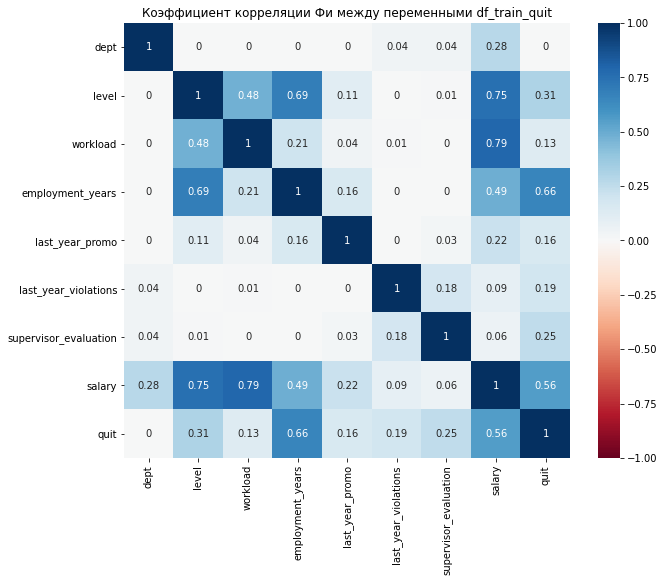

In [112]:
# Вычисляем матрицу корелляций Фи
phi_corr = df_train_phik.phik_matrix(interval_cols = ['salary']).round(2)

# Строим ХитМэп корреляций Фи
plt.figure(figsize = (10, 8))
sns.heatmap(phi_corr, annot = True, cmap = 'RdBu', vmin = -1, vmax = 1)
plt.title("Коэффициент корреляции Фи между переменными df_train_quit")
plt.show()

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`quit (уволился ли сотрудник)`**:
   - **Сильная корреляция**:
     - Прослеживается сильная положительная корреляция с `employment_years` **(0,66)**. Следовательно, можно сделать вывод, чем меньше сотрудник проработал в компании - тем больше он склонен к вольнению и поиску новой работы. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `salary` **(0,56)** показывает нам, что чем меньше заработная плата сотрудника, тем меньше он держится за своё рабочее место. 

### 3.2 Работаем с целевой признаком тестовой выборки `df_test_target_quit`/2

Как и в предыдущем шаге, данные должны быть пропорциональны тренировочной выборке, давайте в этом убедимся:

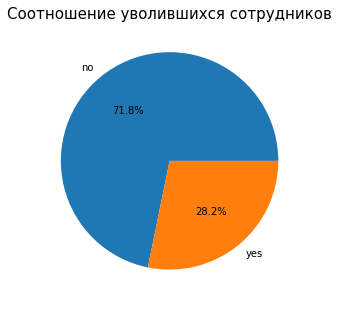

In [113]:
(
    df_test_target_quit
    .groupby('quit')['id']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%')
)
plt.title('Соотношение уволившихся сотрудников', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Данные пропорциональны тренировочной выборке. 

### 3.3 Составим портрет уволившегося сотрудника: 

Соберем данные по всем признакам:

In [114]:
df_train_quit.groupby('quit')['dept'].value_counts(normalize = True)

quit  dept      
no    sales         0.358983
      technology    0.227019
      purchasing    0.146936
      marketing     0.145891
      hr            0.121170
yes   sales         0.360816
      technology    0.244681
      purchasing    0.147163
      marketing     0.144504
      hr            0.102837
Name: dept, dtype: float64

1. **Sales**: В отделе продаж доля ушедших порядка 36%. Максимальный показатель среди отделов компании может свидетельствовать о проблемах с подбором персонала или мотивацией. (К примеру принимают студентов без опыта и не стимулируют их процентом от продаж.) Либо выгорании работников продаж от высокой нагрузки. 

2. **Technology**: Показатель доли ушедших – порядка 24%. Это так же может говорить о высокой рабочей нагрузке, выгорании работников специалистов технического отдела. 

3. **Purchasing**: Доля уволившихся в этом отделе составляет порядка 15%. Для отдела снабжения характерны те же причины увольнения, как и в других отделах, так и специфические - например вынужденные увольнения из за сокращения поставок и уменьшения количества поставщиков, отсюда допустим уменьшение бонусов и вот уже сотрудник ищет себе место работы получше. 

4. **Marketing**: Показатель доли ушедших - порядка 14%. Весомый показатель, хотелось бы иметь статистику по вновь принятым работникам, для лучшего понимания ситуации с кадрами в компании. 

5. **HR**: Доля ушедших составляет 10%. Минимальный показатель среди отделов компании. Неплохо было бы узнать у руководителя отдела - какими принципами он руководствуется в своей работе с подчиненными !  

In [115]:
df_train_quit.groupby('quit')['level'].value_counts(normalize = True)

quit  level 
no    middle    0.552228
      junior    0.329387
      senior    0.118384
yes   junior    0.889184
      middle    0.095745
      senior    0.015071
Name: level, dtype: float64

1. **junior**: Доля уволившихся джунов порядка 89%, что немного настораживает. Возможно компании не хватает опыта в работе с молодыми специалистами.  

2. **middle**: Показатель доли ушедших – порядка 9%. На порядок меньше увольнений, возможно, это связано с тем, что тут работают уже взрослые, осознанные люди, которые не будут прыгать с места на место.

3. **senior**: Доля уволившихся порядка 2 %. На мой взгляд - приемлемый показатель, свявзанный с естественными обстоятельствами. 

In [116]:
df_train_quit.groupby('quit')['workload'].value_counts(normalize = True)

quit  workload
no    medium      0.567549
      low         0.239903
      high        0.192549
yes   low         0.460106
      medium      0.432624
      high        0.107270
Name: workload, dtype: float64

1. **low**: Доля уволившихся порядка 46%, вероятно малонагруженность работников отражается на их заработной плате.  

2. **medium**: Доля уволившихся порядка  43% сапоставимо с малонагруженными сотрудниками, однако у средничков могут быть свои причины на увольнение, связанные, например с нереализованными амбициями, желанием работать меньше/получать больше.  

3. **high**: Доля уволившихся порядка 10%. Не все справляются с большими нагрузками. 

In [117]:
df_train_quit.groupby('quit')['employment_years'].value_counts(normalize = True)

quit  employment_years
no    2                   0.169568
      1                   0.134401
      4                   0.127437
      5                   0.118036
      3                   0.110028
      7                   0.104805
      6                   0.099582
      8                   0.059540
      9                   0.046309
      10                  0.030292
yes   1                   0.531028
      2                   0.257092
      3                   0.144504
      4                   0.023936
      5                   0.020390
      6                   0.008865
      7                   0.006206
      8                   0.002660
      9                   0.002660
      10                  0.002660
Name: employment_years, dtype: float64

Сотрудники отработавшие один год - увольняются в 53% случаев, то есть увольняется каждый второй сотрудник. \
Так же по динамике увольнений можно сказать, что для капитального удержания в компании, достаточно "завлечь" работника на 3 года, дальше вероятность его ухода будет крайне мала. 

In [118]:
df_train_quit.groupby('quit')['last_year_promo'].value_counts(normalize = True)

quit  last_year_promo
no    no                 0.961003
      yes                0.038997
yes   no                 0.999113
      yes                0.000887
Name: last_year_promo, dtype: float64

99,9 % уволившихся работников - не получали повышение в прошлом году. Отсутствие динамики в карьерной лестнице - могло стать решающим фактором.  

In [119]:
df_train_quit.groupby('quit')['last_year_violations'].value_counts(normalize = True)

quit  last_year_violations
no    no                      0.889624
      yes                     0.110376
yes   no                      0.797872
      yes                     0.202128
Name: last_year_violations, dtype: float64

Из уволившихся сотрудников - порядка 80% не имели за собой нарушений, тогда как 20% всё же попадались на злоупотреблении полномочиями. 

In [120]:
df_train_quit.groupby('quit')['supervisor_evaluation'].value_counts(normalize = True)

quit  supervisor_evaluation
no    4                        0.476323
      3                        0.247214
      5                        0.160167
      2                        0.079039
      1                        0.037256
yes   3                        0.463652
      4                        0.253546
      2                        0.145390
      1                        0.084220
      5                        0.053191
Name: supervisor_evaluation, dtype: float64

Среди сотрудников с оценкой от руководителя "3" - увольняется порядка 46%. С оценкой "4" - порядка 25%. 
Стоит отметить, что работники с отличной оценкой - увольняются в 5% случаев, что доказывает тот факт, что люди держатся вокруг руководителя, с которым у них хорошие отношения. 

In [121]:
df_train_quit.pivot_table( values = 'salary', index = 'quit', aggfunc = 'mean')

,salary
quit,
no,37702.228412
yes,23885.106383


Средняя ЗП уволившихся сотрудников почти на 14 000 меньше средней ЗП, тех, кто продолжает работать в компании.

Изучив все признаки в контексте целевого, можно сделать вывод:\
Что максимальную предрасположенность к увольнению будет иметь работник со *стаже работы* в компании **1 год**, с *заработной платой* от **12 до 23 тысяч** рублей, занимающий *позицию* **junior** в **отделе продаж**, с **низкой нагрузкой** и *оценкой руководителя* на **3 балла** из 5, **без повышения** в течение последнего года.

### 3.4 Проследим влияние удовлетворенностью работы на увольнение: 

Используем данные целевых тестовых выборок:

In [122]:
df_satisfaction_quit = df_test_target.merge(df_test_target_quit, on = 'id', how = 'left')

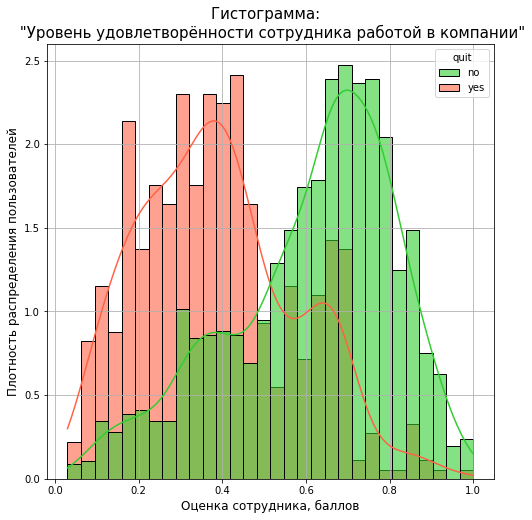

In [123]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'no': 'limegreen', 'yes': 'tomato'}
sns.histplot(data = df_satisfaction_quit, 
             bins = 30,
             kde = True,
             ax=ax, 
             stat='density', 
             common_norm = False,
             hue = 'quit', 
             x = 'job_satisfaction_rate',
             palette = palette,
             alpha = 0.6)
plt.title('Гистограмма:  \n "Уровень удовлетворённости сотрудника работой в компании"', size = 15)
plt.xlabel('Оценка сотрудника, баллов', size = 12)
plt.ylabel('Плотность распределения пользователей', size = 12)
plt.grid(True)
plt.show()

Гистограмма показала, что менее удовлетворенные сотрудники - первые кандидаты на увольнение. 

### ВЫВОД по разделу: 
По мере изучения входящих признаков в контексте целевого - мы составили портрет уволившегося сотрудника:
*Стаж работы* в компании от **1 до 2 лет**, с *заработной платой* от **12 до 23 тысяч** рублей, занимали *позицию* **junior** в **отделе продаж**, с **низкой нагрузкой** и *оценкой руководителя* на **3 балла** из 5, **без повышения** в течение последнего года.

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`quit (уволился ли сотрудник)`**:
   - **Сильная корреляция**:
     - Прослеживается сильная положительная корреляция с `employment_years` **(0,66)**. Следовательно, можно сделать вывод, чем меньше сотрудник проработал в компании - тем больше он склонен к вольнению и поиску новой работы. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `salary` **(0,56)** показывает нам, что чем меньше заработная плата сотрудника, тем меньше он держится за своё рабочее место.

А так же проследили влияние удовлетворенности сотрудника работтой на увольнение: \
Менее удовлетворенные сотрудники - первые кандидаты на увольнение.

## Шаг 4. Добавление нового входного признака/2

In [124]:
df_test_features = df_test_features.set_index('id')

In [125]:
df_test_features['job_satisfaction_rate'] = best_model.predict(df_test_features)
df_test_features.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.840164
686555,hr,junior,medium,1,no,no,4,30000,0.673437
467458,sales,middle,low,5,no,no,4,19200,0.654286
418655,sales,middle,low,6,no,no,4,19200,0.654286
789145,hr,middle,medium,5,no,no,5,40800,0.816098


Новый входной признак добавлен в тестовую выборку.

Думаю, необходимо добавить новый входной признак и в тренировочную выборку:

In [126]:
df_train_quit_preds = df_train_quit.drop(['id','quit'], axis = 1)

In [127]:
df_train_quit['job_satisfaction_rate'] = best_model.predict(df_train_quit_preds)
df_train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.651778
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.840164
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.825185


Новый входной признак добавлен в тренировочную выборку.

## Шаг 5. Подготовка данных/2

Наши данные изначально были разделены на тренировочную, тестовую и целевую тестовую выборки.
Мы переберем модели **DecisionTreeRegressor()**, **LogisticRegression()**, **KNeighborsClassifier()** и **SVC()** используя пайплайны.

In [128]:
#df_train_quit['quit'] = df_train_quit['quit'].apply( lambda x: 1 if x == 'yes' else 0 )

In [129]:
# Так как столбец ID напрямую коррелирует с уровнем удовлетворености, сделаем его индексом, чтобы видеть в будущем какие пользователи конкретно
# могут быть нам инетерсно в персональной работе по увеличению удовлетворённости сотрудника работой в компании
df_train_quit = df_train_quit.set_index('id')

По условию задачи нам необходимо для кодирования категориальных признаков использовать как минимум два кодировщика:\
OneHotEncoder поможет нам закодировать бинарные переменные. \
OrdinalEncoder обычно используется, если важен естественный порядок.

- Перечислим особенности данных:\
Целевой признак — `quit (уволился ли сотрудник)`.\
Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью `OneHotEncoder`.\
Два признака: `workload` и `level` — закодируем с помощью `OrdinalEncoder`.\
Остальные количественные признаки необходимо масштабировать.

In [130]:
# Используемые константы
RANDOM_STATE = 42

In [131]:
X_train = df_train_quit.drop(['quit'], axis = 1)
y_train = df_train_quit['quit']

In [132]:
# Закодируем целевой признак:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [133]:
# введем обозначение для типов исходных данных:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['workload', 'level']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [134]:
# Добавляем OHE-кодирование в пайплайн
try:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') # заполняем пропуски из шага предобработки данных
        ),
        (
            'ohe', 
            OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)
        )
    ]
) 
except:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
        )
    ]
) 

In [135]:
# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                    ['low', 'medium', 'high'], 
                    ['junior', 'middle', 'senior'] 
                ], 
                handle_unknown = 'use_encoded_value', unknown_value = np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )
    ]
) 

In [136]:
#Объединяем шаги подготовки
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder = 'drop' 
) 

In [137]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor())
    ]
) 

## Шаг 6. Обучение модели/2

In [138]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 5), #  ограничивает максимальную глубину дерева
        'models__max_features': range(2, 5), # контролирует максимальное количество признаков, рассматриваемых при каждом разбиении узла в дереве
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5), # число k-ближайших соседей
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state = RANDOM_STATE, 
            class_weight = 'balanced', # использует значения для автоматической настройки весов, обратно пропорциональных частотам классов
            solver = 'liblinear',  # алгоритм, который подходит для небольших наборов данных и обрабатывает L1-регуляризацию
            penalty = 'l1' # L1-регуляризация (лассо-регуляризация)
        )],
        'models__C': range(1, 5), # сложность модели чем выше, тем более сложные зависимости в данных модель может восстанавливать
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state = RANDOM_STATE, 
            kernel = 'poly', # используем полиноминальное ядро
            probability = True 
        )],
        'models__degree': range(2, 3), # значение степени
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Мы можем перебрать гиперпараметры тремя методами: 
1. GridSearchCV - это метод (его ещё называют поиск по сетке), который перебирает все возможные комбинации гиперпараметров, что может быть вычислительно дорого.
2. RandomizedSearchCV - это метод случайного поиска гиперпараметров (проверяет только случайное подмножество комбинаций), который часто оказывается более эффективным, чем полный перебор.
3. OptunaSearchCV - (Байесовская оптимизация) - это итерационный метод, на каждой итерации определяется, в какой следующей точке с наибольшей вероятностью можно получить лучший результат.

Для нашего исследования я выбрал модель `RandomizedSearchCV` - так как она позволяет быстрее найти хорошие параметры, хотя и жертвуя полной оптимальностью.

Метрика оценки качества в этой задаче — **ROC-AUC**. \
Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.

In [139]:
# выполним автоматизированный поиск гиперпараметров с помощью RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

### 6.1 Выберим лучшую модель/2: 
Посмотрим ТОП-5 моделей:

In [140]:
random_search.fit(X_train, y_train)
pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score', ascending = True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.158839,0.060538,0.015379,0.001045,MinMaxScaler(),3.0,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.924279,0.911927,0.913761,0.910948,0.927025,0.917588,0.006703,1
2,0.182097,0.000860,0.014950,0.000239,MinMaxScaler(),4.0,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.924303,0.911890,0.913877,0.910964,0.926870,0.917581,0.006654,2
1,0.164033,0.025044,0.014967,0.000369,MinMaxScaler(),2.0,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.924311,0.911941,0.913465,0.910594,0.927203,0.917503,0.006862,3
4,0.024902,0.001127,0.012608,0.000423,StandardScaler(),NaN,DecisionTreeClassifier(random_state=42),4.0,4.0,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.911328,0.904171,0.908060,0.907094,0.926665,0.911464,0.007937,4
9,0.026429,0.001561,0.021583,0.000849,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,3.0,"{'preprocessor__num': StandardScaler(), 'model...",0.898424,0.908691,0.896399,0.901999,0.929230,0.906948,0.011899,5


ТОП-3 позиции удерживает **LogisticRegression()**, далее идут DecisionTreeClassifier() и KNeighborsClassifier().

In [141]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)
print('Параметры лучшей модели: \n', random_search.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before

Посмотрим на значения нашей метрики на тестовой выборке: 

In [142]:
# для начала соберем полную тестовую выборку:
df_test_features_full_hd = df_test_features.merge(df_test_target_quit, on = 'id', how = 'left')
# сделаем столбец ID индексом
df_test_features_full_hd = df_test_features_full_hd.set_index('id')
# выделим входящий и целевой признаки - вроде бы делаем обратное действие, но теперь наши выборки упорядочены по ID: 
X_test = df_test_features_full_hd.drop(['quit'], axis = 1)
y_test = df_test_features_full_hd['quit']
# Закодируем целевой признак:
y_test = le.transform(y_test)
# обозначаем нашу лучшую модель:
best_model_two = random_search.best_estimator_

In [143]:
# проверим работу модели на тестовой выборке и рассчитаем прогноз на тестовых данных
y_test_proba = random_search.predict_proba(X_test)
y_test_proba_one = y_test_proba[:, 1]

In [146]:
print(f'Площадь ROC-кривой:{round(roc_auc_score(y_test, y_test_proba_one), 2)}')

Площадь ROC-кривой:0.91


Критерий успеха выполняется ! 

## Шаг 7. Выводы по задаче:
На 6 шаге мы перебрали на тестовой выборке модели **DecisionTreeRegressor()**, **LogisticRegression()**, **KNeighborsClassifier()** и **SVC()** используя пайплайны.\
Лучшей моделью по метрике **ROC-AUC** оказалось **Логистическая регрессия** со следующими параметрами:\
`C` = **4**,\
`class_weight` = **'balanced'**,\
`penalty` = **'l1'**,\
`solver` = **'liblinear'**.

*Метрика* **ROC-AUC** на тренировойной выборке: **0.92**

*Метрика* **ROC-AUC** на тестовой выборке: **0.91**

Показатели метрики хорошие, критерий успеха выполняется. 

На мой взгляд, в данной ситуации, качество моделей логистической регрессии лучше, так как в данной задаче рассматривается *бинарная классификация* и для расчета метрики **ROC-AUC** используются *вероятности* классов, которые проблематично получить из дерева решений. Логистическая регрессия сама по себе очень хорошо подходит для метрики **ROC-AUC**, если бы мы рассматривали другую метрику - вероятно и в топе была бы другая модель.  

## ОБЩИЙ ВЫВОД:
В данном исследовании перед нами стояла задача разработать решение, которое позволит бизнесу избежать финансовых потерь и оттока сотрудников.\
Ход решения разделен на 2 подзадачи:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

   Задача 1.

**ШАГ 1 - Загрузка данных**\
В нашем распоряжении датафреймы:
- `df_train_job` на **10** колонок и **4000** строк;
- `df_test_features` на **9** колонок и **2000** строк;
- `df_test_target` на **2** колонки и **2000** строк.
  
Названия столбцов соответствуют общепринятым нормам.\
Пропуски в данных обнаружены в столбцах `dept` и `level` датафреймов `df_train_job` и `df_test_features`.

Для корректного исследования необходимо предобработать данные, а именно:
- Избавиться от пропусков в данных;
- Проверить датафреймы на явные/неявные дубликаты.

**ШАГ 2 - Предобработка данных**\
На этапе предобработки данных была проведена проверка датафреймов на явные/неявные дубликаты.\
Обнаружены неявные дубликаты `' '`/nan в столбцах `workload` и `dept` датафрейма `df_test_features`. \
Данные пробелы заменены на nan, для дальнейшего заполнения пропусков в пайплайне на этапе обучения модели с использованием **SimpleImputer()**. 

**ШАГ 3 - Исследовательский анализ данных**\
- Большинство сотрудников работают в компании от 1 до 2 лет, тогда как среднее значение длительности составляет 3,7 лет.
- Распределение оценок руководителем похоже на нормальное, со сдвигом вправо.\
Больше всего сотрудников с оценкой 4, тогда как, в среднем, оценка персонала глазами руководителя составляет 3,5 балла.
- Медианная зарплата в компании составляет 30000 рублей, эта сумма не учитывает высокие значения заработных плат руководителей.
- В среднем, работники компании удовлетворены своей работой на 0,53 балла.\
Работодателю есть куда расти. Распределение имеет бимодальный вид, где мы видим, что большинство сотрудников удовлетворены своей работой.
- Большинство работников работает в отделе продаж - порядка 40%.
- Большинство сотрудников компании - работники начального уровня, в то же время middle-работников немного меньше, но они тоже занимают значительную часть.
- Более половины работников имеют средний уровень загруженности.
- Скромная статистика по продвижению по карьерной лестнице - всего 3% сотрудников получали повышение за год. 
- За последний год было выявлено 14% нарушителей трудового договора, к счастью, большинство сотрудников добропорядочные.

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`job_satisfaction_rate (уровень удовлетворённости сотрудника работой в компании)`**:
   - **Сильная корреляция**:
     - Прослеживается сильная положительная корреляция с `supervisor_evaluation` **(0,76)**. Следовательно, можно сделать вывод, что если руководитель работником доволен и они с ним в хороших отношениях - то и работой в компании сотрудник будет удовлетворен. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `last_year_violations` **(0,56)**, `employment_years` **(0,33)** показывает нам, что отсутствие нарушений трудового договора, а следовательно и санкций за эти нарушения положительно влияют на оценку удовлетворенности, так же как и длительность работы в компании: дольше работаешь - больше знаешь, всё больше попадаешь в зону комфорта и повышаешь уровень удовлетворенности работой.\

Так же отмечу высокую корреляцию занимаемой доолжности `level` с `salary` **(0,72)** и `employment_years` **(0,68)** - что говорит нам о том, что со временем персонал должен проходить через карьерный рост, что обеспечит повышение заработной платы. 

Нельзя не упомянуть, что высокозагруженные работники имеют большую заработную плату, и это отражено в самой высокой корреляции `workload` и `salary` **(0,79)**.

Отмечу, что предоставленные работодателем выборки корректно поделены на тестовую и тренировочную.

**ШАГ 4 - Подготовка данных**\
Для переборки моделей DecisionTreeRegressor() и LogisticRegression() собрали данные в пайплайны.

**ШАГ 5 - Обучение модели**\
На 5 шаге мы перебрали на тестовой выборке модели **LogisticRegression()** и **DecisionTreeRegressor()** используя пайплайны.\
Лучшей моделью по метрике **SMAPE** оказалось **Дерево решений** со следующими параметрами:\
`models__min_samples_split`= **11**,\
`models__max_features` = **8**, \
`models__max_depth` = **12**.

*Метрика* **SMAPE** на тренировойной выборке: **15,70**

*Метрика* **SMAPE** на тестовой выборке: **14,05**

Показатели метрики хорошие, критерий успеха выполняется. 

На мой взгляд, в данной ситуации, качество моделей дерева решений лучше, так как DecisionTree автоматически находит сложные нелинейные закономерности, разбивая данные на области - а как мы видили в матрице корреляций Фи - у нас многие параметры слабо коррелируют между собой или не коррелируют вовсе. \
Логистическая регрессия ищет в первую очередь линейные связи, которых в наших данных не много. 

 Задача 2.
**ШАГ 1 - Загрузка данных**\
В нашем распоряжении датафреймы:
- `df_train_quit` на **10** колонок и **4000** строк;
- `df_test_features` на **9** колонок и **2000** строк - тот же самый из первой задачи.
- `df_test_target_quit` на **2** колонки и **2000** строк.
  
Названия столбцов соответствуют общепринятым нормам.
Пропуски в данных имеются в датафрейме `df_test_features`, но они будут обработаны на этапе конструирования пайплайна. 

Для корректного исследования необходимо предобработать данные, а именно:
- Проверить датафреймы на явные/неявные дубликаты.

**ШАГ 2 - Предобработка данных**\
На этапе предобработки данных была проведена проверка датафреймов на явные/неявные дубликаты, дубликаты не обнаружены. 

**ШАГ 3 - Исследовательский анализ данных**\  
По мере изучения входящих признаков в контексте целевого - мы составили портрет уволившегося сотрудника:
*Стаж работы* в компании от **1 до 2 лет**, с *заработной платой* от **12 до 23 тысяч** рублей, занимали *позицию* **junior** в **отделе продаж**, с **низкой нагрузкой** и *оценкой руководителя* на **3 балла** из 5, **без повышения** в течение последнего года.

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`quit (уволился ли сотрудник)`**:
   - **Сильная корреляция**:
     - Прослеживается сильная положительная корреляция с `employment_years` **(0,66)**. Следовательно, можно сделать вывод, чем меньше сотрудник проработал в компании - тем больше он склонен к вольнению и поиску новой работы. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `salary` **(0,56)** показывает нам, что чем меньше заработная плата сотрудника, тем меньше он держится за своё рабочее место.

А так же проследили влияние удовлетворенности сотрудника работтой на увольнение: \
Менее удовлетворенные сотрудники - первые кандидаты на увольнение.

**ШАГ 4 - Добавление нового входного признака**\
На данном этапе мы добавили новый входной признак `job_satisfaction_rate` в тренировочную и тестовую выборку.

**ШАГ 5 - Подготовка данных**\
Мы Собрали данные для моделей **DecisionTreeRegressor()**, **LogisticRegression()**, **KNeighborsClassifier()** и **SVC()** используя пайплайны.

**ШАГ 6 - Обучение модели**\
На 6 шаге мы перебрали на тестовой выборке модели **DecisionTreeRegressor()**, **LogisticRegression()**, **KNeighborsClassifier()** и **SVC()** используя пайплайны.\
Лучшей моделью по метрике **ROC-AUC** оказалось **Логистическая регрессия** со следующими параметрами:\
`C` = **4**,\
`class_weight` = **'balanced'**,\
`penalty` = **'l1'**,\
`solver` = **'liblinear'**.

*Метрика* **ROC-AUC** на тренировойной выборке: **0.92**

*Метрика* **ROC-AUC** на тестовой выборке: **0.91**

Показатели метрики хорошие, критерий успеха выполняется. 

На мой взгляд, в данной ситуации, качество моделей логистической регрессии лучше, так как в данной задаче рассматривается *бинарная классификация* и для расчета метрики **ROC-AUC** используются *вероятности* классов, которые проблематично получить из дерева решений. Логистическая регрессия сама по себе очень хорошо подходит для метрики **ROC-AUC**, если бы мы рассматривали другую метрику - вероятно и в топе была бы другая модель. 



**РЕКОМЕНДАЦИЯ ДЛЯ БИЗНЕСА:**
Обратить внимание, что зарплатные ожидания "продажников" скорее всего выше, чем получается на самом деле, поэтому сотрудников хватает всего на один год:
- Предлагаю ввести систему премирования отдела продаж по типу **бонуса от объема продаж**.\
Необходимо увеличивать уровень удовлетворенности сотрудников:
- Проводить **курсы повышения квалификации** для перевода работников на новые должности,
- Внедрять программы для **молодых специалистов** с примерами выдающихся работников кадрового резерва.
- Прежде всего работник приходит **на работу за деньгами** - вопрос для руководствакомпании: возможно стоит потерять в прибыли, но получить в рабочей силе !
- Продолжать **проводить опросы** работников и смотреть за динамикой изменений **ключевых** показателей.